In [1]:
 '''
 Academic Integrity Statement
 "I (We) certify that the code and data in this assignment were generated independently,
 using only the tools and resources defined in the course and that I (we) did not receive
 any external help, coaching or contributions during the production of this work."
'''

'\nAcademic Integrity Statement\n"I (We) certify that the code and data in this assignment were generated independently,\nusing only the tools and resources defined in the course and that I (we) did not receive\nany external help, coaching or contributions during the production of this work."\n'

# **Part 2.1, GRID ENVIRONEMNT**

In [2]:
!pip install gym
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from collections import namedtuple, deque
import random
import torch
import torch.nn as nn
from itertools import count

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
class DeterministicGridEnvironment(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self):
    self.observation_space = spaces.Discrete(16)
    self.action_space = spaces.Discrete(4)
    self.max_timesteps = 100
    self.rewards = np.array([[0,0,-6,0],[0,0,0,-6],[0,0,0,0],[5,0,5,10]])
    self.actions = {0:"Down",1:"Up",2:"Right",3:"Left"}
  
  def get_action(self, action):
    return self.actions[action]

  def reset(self):
    self.timestep = 0
    self.agent_pos = [0, 0]
    self.goal_pos = [3, 3]
    self.state = np.zeros((4, 4))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.rewards = np.array([[0,0,-6,0],[0,0,0,-6],[0,0,0,0],[5,0,5,10]])
    observation = self.state.flatten()
    return observation

  def step(self, action):
    done = False
    self.state = np.random.choice(self.observation_space.n)
    if action == 0:
      self.agent_pos[0] += 1
    if action == 1:
      self.agent_pos[0] -= 1
    if action == 2:
      self.agent_pos[1] += 1
    if action == 3:
      self.agent_pos[1] -= 1
    
    self.agent_pos = np.clip(self.agent_pos, 0, 3)
    self.state = np.zeros((4,4))
    if all(self.agent_pos == self.goal_pos):
      self.state[tuple(self.agent_pos)] = 1
      done = True
    else:
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()
    reward = self.rewards[tuple(self.agent_pos)]
    self.rewards[tuple(self.agent_pos)] = 0
    self.timestep += 1
    if self.timestep >= self.max_timesteps:
      done = True
    info = {}

    return observation, reward, done, info

  def render(self):
    cmap=plt.cm.gnuplot
    plt.imshow(self.state,cmap=cmap)
    plt.imshow(self.rewards,cmap=plt.cm.brg,alpha=0.7)
    plt.show()

In [4]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward' , 'done'))

class ReplayMemory(object):

    def __init__(self, capacity, observation_size):
        self.capacity = capacity
        self.curr_state= torch.zeros(capacity , observation_size)
        self.action = torch.zeros(capacity , 1)
        self.next_state= torch.zeros(capacity,  observation_size)
        self.reward = torch.zeros(capacity, 1)
        self.done = torch.zeros(capacity , 1)
        self.num_in_queue = 0
        self.ending_position = 0

    def push(self, state ,action , reward, next_state, done):
        self.curr_state[self.ending_position] = state.float()
        self.action[self.ending_position] = float(action)
        self.reward[self.ending_position] = float(reward)
        self.next_state[self.ending_position] = next_state.float()
        self.done[self.ending_position] = done
        self.ending_position = (self.ending_position + 1) % self.capacity
        self.num_in_queue = min(self.num_in_queue + 1 , self.capacity)
      
    def sample(self, batch_size):
        indexer = random.choices(range(self.num_in_queue) , k = batch_size)
        state = self.curr_state[indexer]
        reward = self.reward[indexer]
        action = self.action[indexer]
        next_state = self.next_state[indexer]
        done = self.done[indexer]
        return state, reward ,action , next_state ,done

    def __len__(self):
        return self.num_in_queue

In [5]:
class DQNNetwork(nn.Module):
  def __init__(self , input_size , hidden_layer, output_size) -> None:
    super(DQNNetwork , self).__init__()
    self.fc1 = nn.Linear(input_size,hidden_layer)
    self.leakyrelu = nn.LeakyReLU()
    self.relu  = nn.ReLU()
    self.fc2 = nn.Linear(hidden_layer , hidden_layer *2)
    self.fc3 = nn.Linear(hidden_layer*2 , output_size)

  def forward(self , x):
    x = self.fc1(x)
    x = self.leakyrelu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x

In [65]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 0.999
TARGET_UPDATE =4
episodes  = 200
lr = 0.001
epsilon_values = []
environment = DeterministicGridEnvironment()
n_states = environment.observation_space.n
n_actions = environment.action_space.n
train_network = DQNNetwork(n_states , 64, n_actions)
target_network = DQNNetwork(n_states , 64, n_actions)

def next_action(state,actions):
  global epsilon
  epsilon = epsilon * EPS_DECAY
  epsilon_values.append(epsilon)
  if epsilon < EPS_END:
    epsilon = EPS_END
  prob =np.random.rand()
  if prob > epsilon:
    action = torch.argmax(train_network(state))
    return action.numpy()
  else:
    action = np.random.randint(actions)
  return action


In [39]:
memory = ReplayMemory(5000, environment.observation_space.n)

In [40]:
def train():
  if  len(memory) < BATCH_SIZE:
    return
  optimizer.zero_grad()
  curr_state, reward, action , next_state, done = memory.sample(BATCH_SIZE)
  curr_values = train_network(curr_state).gather(1, action.long())
  target =  reward + torch.mul((GAMMA *target_network(next_state).max(1).values.unsqueeze(1)), 1 - done)
  loss = criterion(curr_values , target)
  loss.backward()
  optimizer.step()
  return loss


In [41]:
def get_one_hot_encoding(state):
  if state is None:
    return None
  index, = np.where(np.isclose(state, 1))
  return nn.functional.one_hot(torch.tensor(index) , len(state)).to(torch.float)

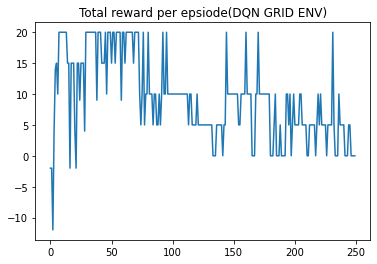

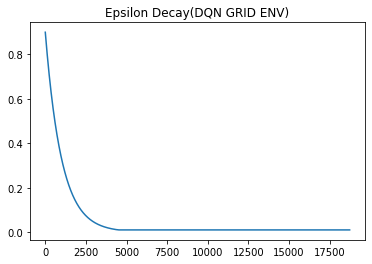

In [42]:
cum_rewards = []
epsilon = EPS_START
BATCH_SIZE = 256
optimizer = torch.optim.Adam(train_network.parameters() ,lr)
criterion = nn.MSELoss()

for i in range(episodes):
  state = get_one_hot_encoding(environment.reset())
  rewards = 0
  for j in count():
    action= next_action(state, environment.action_space.n)
    observation , reward , done , info = environment.step(action)
    rewards +=reward
    next_state = get_one_hot_encoding(observation)
    memory.push(state, action , reward,next_state, float(done)),
    state = next_state
    loss = train() 
    if done:
      cum_rewards.append(rewards)
      break
  if (i+1) % TARGET_UPDATE == 0:
    target_network.load_state_dict(train_network.state_dict())
plt.title("Total reward per epsiode(DQN GRID ENV)")
plt.plot(cum_rewards)
plt.show()
plt.title("Epsilon Decay(DQN GRID ENV)")
plt.plot(epsilon_values)

# **Part 2.2 CartPole v1**

In [43]:
environment2 = gym.make('CartPole-v1')
train_network = DQNNetwork(4 , 64 , environment2.action_space.n)
target_network = DQNNetwork(4, 64, environment2.action_space.n)
print(train_network)

DQNNetwork(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


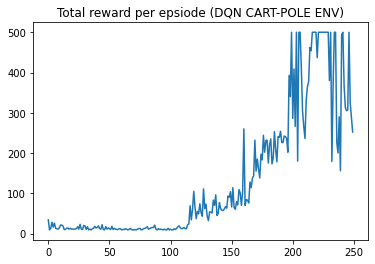

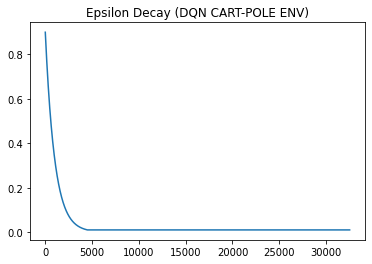

In [44]:
cum_rewards = []
epsilon_values = []
episodes = 250
epsilon = EPS_START
BATCH_SIZE= 128
optimizer = torch.optim.Adam(train_network.parameters() ,lr)
criterion = nn.MSELoss()
memory = ReplayMemory(5000 , environment2.observation_space.shape[0])
for i in range(episodes):
  state = torch.tensor(environment2.reset())
  rewards = 0
  for j in count():
    action= next_action(state, environment2.action_space.n)
    observation , reward , done , info = environment2.step(action)
    rewards +=reward
    next_state = torch.tensor(observation)
    memory.push(state, action , reward,next_state, float(done)),
    state = next_state
    loss = train()
    if done:
      cum_rewards.append(rewards)
      break
  if (i+1) % TARGET_UPDATE == 0:
    target_network.load_state_dict(train_network.state_dict())
plt.title("Total reward per epsiode (DQN CART-POLE ENV)")
plt.plot(cum_rewards)
plt.show()
plt.title("Epsilon Decay (DQN CART-POLE ENV)")
plt.plot(epsilon_values)

# **Part 2.2 Mountain Car**

In [66]:
environment3 = gym.make("MountainCar-v0")
obs = environment3.reset()

In [67]:
train_network = DQNNetwork(2 , 64 , environment3.action_space.n)
target_network = DQNNetwork(2, 64, environment3.action_space.n)
print(train_network)

DQNNetwork(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)


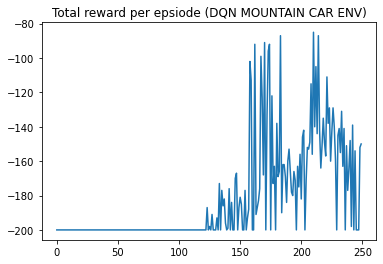

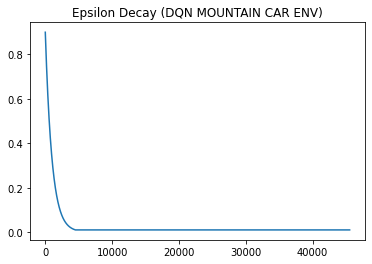

In [68]:
cum_rewards = []
epsilon_values = []
episodes = 250
epsilon = EPS_START
BATCH_SIZE= 128
optimizer = torch.optim.Adam(train_network.parameters() ,lr)
criterion = nn.MSELoss()
memory = ReplayMemory(5000 , environment3.observation_space.shape[0])
for i in range(episodes):
  state = torch.tensor(environment3.reset())
  rewards = 0
  for j in count():
    action= next_action(state, environment3.action_space.n)
    observation , reward , done , info = environment3.step(action)
    rewards +=reward
    next_state = torch.tensor(observation)
    memory.push(state, action , reward,next_state, float(done)),
    state = next_state
    loss = train()
    if done:
      cum_rewards.append(rewards)
      break
  if (i+1) % TARGET_UPDATE == 0:
    target_network.load_state_dict(train_network.state_dict())
plt.title("Total reward per epsiode (DQN MOUNTAIN CAR ENV)")
plt.plot(cum_rewards)
plt.show()
plt.title("Epsilon Decay (DQN MOUNTAIN CAR ENV)")
plt.plot(epsilon_values)

# **PART 3.1 DOUBLE DQN FOR GRID ENVIRONMENT**

In [56]:
def ddqn_train():
  if  len(memory) < BATCH_SIZE:
    return
  optimizer.zero_grad()
  curr_state, reward, action , next_state, done = memory.sample(BATCH_SIZE)
  curr_values = train_network(curr_state).gather(1 , action.long())
  next_values = train_network(next_state)
  argmax_actions = torch.argmax(next_values,dim=1).reshape(BATCH_SIZE , 1)
  target =  reward + torch.mul((GAMMA *target_network(next_state).gather(1, argmax_actions)), 1 - done)
  loss = criterion(curr_values , target)
  loss.backward()
  optimizer.step()
  return loss

In [57]:
train_network = DQNNetwork(16, 64 , environment.action_space.n)
target_network = DQNNetwork(16, 64, environment.action_space.n)
print(train_network)


DQNNetwork(
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


In [58]:
memory = ReplayMemory(5000 , environment.observation_space.n)

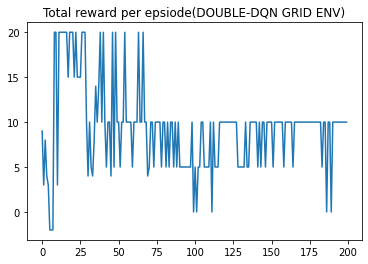

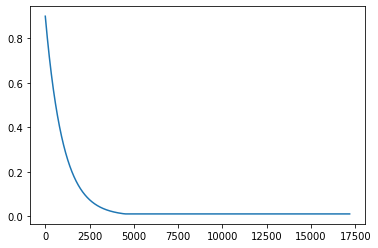

In [59]:
cum_rewards = []
epsilon_values = []
epsilon = EPS_START
BATCH_SIZE = 256
optimizer = torch.optim.Adam(train_network.parameters() ,lr)
criterion = nn.MSELoss()
episodes = 200
momentum = 0.5
for i in range(episodes):
  state = get_one_hot_encoding(environment.reset())
  rewards = 0
  for j in count():
    action= next_action(state, environment.action_space.n)
    observation , reward , done , info = environment.step(action)
    rewards +=reward
    next_state = get_one_hot_encoding(observation)
    memory.push(state, action , reward,next_state, float(done)),
    state = next_state
    loss = ddqn_train() 
    if done:
      cum_rewards.append(rewards)
      break
  if (i+1) % TARGET_UPDATE == 0:
    target_network.load_state_dict(train_network.state_dict())
plt.title("Total reward per epsiode(DOUBLE-DQN GRID ENV)")
plt.plot(cum_rewards)
plt.show()
plt.plot(epsilon_values)

# **PART 3.2 DOUBLE DQN FOR CART-POLE ENVIRONMENT**

In [60]:
environment2 = gym.make('CartPole-v1')
train_network = DQNNetwork(4 , 64 , environment2.action_space.n)
target_network = DQNNetwork(4, 64, environment2.action_space.n)
print(train_network)

DQNNetwork(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


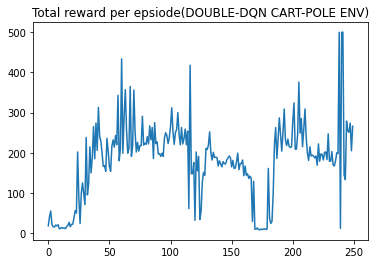

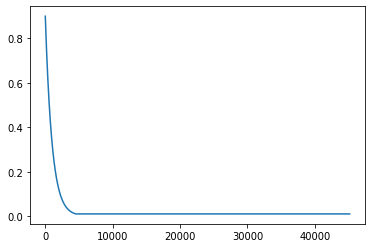

In [61]:
cum_rewards = []
epsilon_values = []
episodes = 250
epsilon = EPS_START
BATCH_SIZE= 128
optimizer = torch.optim.Adam(train_network.parameters() ,lr)
criterion = nn.MSELoss()
memory = ReplayMemory(5000 , environment2.observation_space.shape[0])
for i in range(episodes):
  state = torch.tensor(environment2.reset())
  rewards = 0
  for j in count(): 
    action= next_action(state, environment2.action_space.n)
    observation , reward , done , info = environment2.step(action)
    rewards +=reward
    next_state = torch.tensor(observation)
    memory.push(state, action , reward,next_state, float(done)),
    state = next_state
    loss = ddqn_train()
    if done:
      cum_rewards.append(rewards)
      break
  if (i+1) % TARGET_UPDATE == 0:
    target_network.load_state_dict(train_network.state_dict())
plt.title("Total reward per epsiode(DOUBLE-DQN CART-POLE ENV)")
plt.plot(cum_rewards)
plt.show()
plt.plot(epsilon_values)

# **PART 3.2 DOUBLE DQN FOR MOUNTAIN CAR ENVIRONMENT**

In [69]:
environment3 = gym.make("MountainCar-v0")
obs = environment3.reset()

In [70]:
train_network = DQNNetwork(2 , 64 , environment3.action_space.n)
target_network = DQNNetwork(2, 64, environment3.action_space.n)
print(train_network)

DQNNetwork(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)


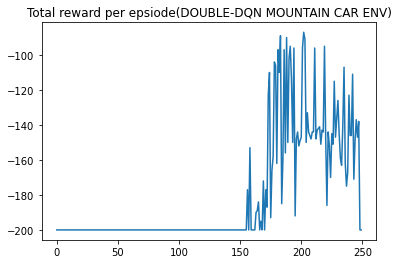

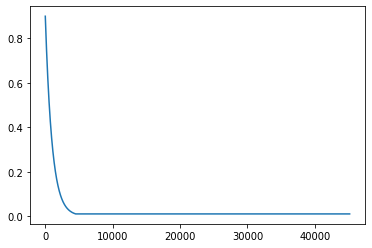

In [71]:
cum_rewards = []
epsilon_values = []
episodes = 250
epsilon = EPS_START
BATCH_SIZE= 128
optimizer = torch.optim.Adam(train_network.parameters() ,lr)
criterion = nn.MSELoss()
memory = ReplayMemory(5000 , environment3.observation_space.shape[0])
for i in range(episodes):
  state = torch.tensor(environment3.reset())
  rewards = 0
  for j in count():
    action= next_action(state, environment3.action_space.n)
    observation , reward , done , info = environment3.step(action)
    rewards +=reward
    next_state = torch.tensor(observation)
    memory.push(state, action , reward,next_state, float(done)),
    state = next_state
    loss = train()
    if done:
      cum_rewards.append(rewards)
      break
  if (i+1) % TARGET_UPDATE == 0:
    target_network.load_state_dict(train_network.state_dict())
plt.title("Total reward per epsiode(DOUBLE-DQN MOUNTAIN CAR ENV)")
plt.plot(cum_rewards)
plt.show()
plt.plot(epsilon_values)